# Moon Cycles Deep Search (v3) — Orb Multiplier Sweep (Full Ephemeris Features)

**Research question (simple):**

- In the full-ephemeris experiment (all bodies + aspects + phases), does changing the *aspect orb strictness* (`orb_mult`) create any *real* predictive edge?

Why we care about `orb_mult`:

- In earlier research we saw a pattern: **narrower orbs** (stricter aspect detection) sometimes improved results.
- If that pattern is real, it should also show up in the full-feature setup.

Why we do a 2-stage process (speed + honesty):

- A full grid over `(orb_mult × gauss_window × gauss_std × models)` is very expensive.
- It also increases the risk of "false discoveries" (you can always find a lucky configuration by brute force).

So we do:

1. **FAST scan**: sweep `orb_mult` with **XGBoost only** and a **smaller Gaussian grid**.
   - Goal: quickly see if any orb range looks promising on *validation*.

2. **FINAL check**: for the best orb(s) from validation, run the **full Gaussian grid** and compare **multiple model families**.
   - Goal: confirm the result is not just one model being lucky.

Honesty rules we follow:

- We select hyperparameters using **validation**.
- We look at **test** only as a final report.
- We print statistical checks (p-value vs 50% and Wilson 95% CI for accuracy) because small improvements can be pure noise.

In [1]:
# ------------------------------
# Imports and project path setup
# ------------------------------

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path('/home/rut/ostrofun')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from RESEARCH2.Moon_cycles.moon_data import (
    MoonLabelConfig,
    load_market_slice,
)
from RESEARCH2.Moon_cycles.ephemeris_data import (
    EphemerisFeatureConfig,
    build_ephemeris_feature_set,
)
from RESEARCH2.Moon_cycles.bakeoff_utils import (
    run_moon_model_bakeoff,
    default_model_specs,
)
from RESEARCH2.Moon_cycles.eval_visuals import (
    VisualizationConfig,
    evaluate_with_visuals,
)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

In [2]:
# ------------------------------
# Configuration block
# ------------------------------

# Market date range.
START_DATE = '2017-11-01'
END_DATE = None

# Caching is essential because ephemeris + model grids are expensive.
USE_CACHE = True
VERBOSE = True

# We are doing a FULL ephemeris experiment in this notebook.
# (Moon-only does not have aspect orbs, so `orb_mult` is irrelevant there.)
FEATURE_SET = 'ephemeris_all'

# Label configuration (same idea as other notebooks).
LABEL_CFG = MoonLabelConfig(
    horizon=1,
    move_share=0.5,
    label_mode='balanced_detrended',
    price_mode='raw',
)

# Orb multipliers we want to test.
# Smaller = stricter aspect detection.
ORB_MULTS = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70]

# Optional: include the historical baseline (0.25) because we already have cached runs for it.
# This makes comparisons easier and saves time.
INCLUDE_BASELINE_ORB_025 = True
BASELINE_ORB_025 = 0.25

# Two-stage search control.
# Stage 1: fast orb scan (smaller Gaussian grid, usually XGB only).
DO_FAST_ORB_SCAN = True

# Stage 2: final confirmation on the best orb(s).
DO_FINAL_FULL_GRID = True

# FAST scan Gaussian grid.
# Why smaller: orb sweep already multiplies runtime.
GAUSS_WINDOWS_SCAN = [151, 201, 251, 301]
GAUSS_STDS_SCAN = [20.0, 30.0, 40.0, 50.0, 70.0]

# FULL confirmation Gaussian grid (same as v2 wide grid).
GAUSS_WINDOWS_FULL = [51, 101, 151, 201, 251, 301, 351, 401]
GAUSS_STDS_FULL = [10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0, 90.0]

# Threshold tuning penalties (same as other notebooks).
THRESHOLD_GAP_PENALTY = 0.25
THRESHOLD_PRIOR_PENALTY = 0.05

# XGBoost params.
XGB_PARAMS = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.03,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'early_stopping_rounds': 50,
}

# Visual style (dark theme).
VIS_CFG = VisualizationConfig(
    rolling_window_days=90,
    rolling_min_periods=30,
    probability_bins=64,
)


def cache_namespace_for_orb(orb_mult: float) -> str:
    """Return a cache namespace that is SAFE for this orb value.

    Why we need this:
    - `run_moon_model_bakeoff()` caches runs using a key that does NOT include orb_mult.
    - So if we reused one namespace for multiple orb values, we could accidentally
      load cached model runs trained on a DIFFERENT orb.

    To keep research honest, we isolate cache namespaces per orb.

    Special case:
    - orb=0.25 is the baseline from v2 and already has cache under 'research2_ephem'.
      We reuse it to save time.
    """

    orb_mult = float(orb_mult)
    if abs(orb_mult - BASELINE_ORB_025) < 1e-12:
        return 'research2_ephem'

    tag = f"{orb_mult:.2f}".replace('.', 'p')
    return f"research2_ephem_orb{tag}"


def make_ephem_cfg(orb_mult: float) -> EphemerisFeatureConfig:
    """Create a feature config for the full-ephemeris feature builder."""

    return EphemerisFeatureConfig(
        coord_mode='both',
        orb_mult=float(orb_mult),
        include_pair_aspects=True,
        include_phases=True,
        add_trig_for_longitudes=True,
        add_trig_for_moon_phase=True,
        add_trig_for_elongations=True,
        exclude_bodies=(),
    )


# Expand ORB_MULTS with baseline if requested.
if INCLUDE_BASELINE_ORB_025 and BASELINE_ORB_025 not in ORB_MULTS:
    ORB_MULTS = sorted(list(ORB_MULTS) + [BASELINE_ORB_025])

print('Config loaded.')
print('ORB_MULTS =', ORB_MULTS)
print('FAST scan grid size =', len(GAUSS_WINDOWS_SCAN) * len(GAUSS_STDS_SCAN))
print('FULL grid size      =', len(GAUSS_WINDOWS_FULL) * len(GAUSS_STDS_FULL))

Config loaded.
ORB_MULTS = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
FAST scan grid size = 20
FULL grid size      = 72


In [3]:
# -------------------------------------------
# Load market data (cached)
# -------------------------------------------

df_market = load_market_slice(
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

print('Market rows :', len(df_market))
print('Market range:', df_market['date'].min().date(), '->', df_market['date'].max().date())
display(df_market.head(5))

📂 Loading from cache: research2_moon__market__2017-11-01__8953c00f.parquet
Market rows : 3017
Market range: 2017-11-01 -> 2026-02-03


,date,close
0,2017-11-01,6737.8
1,2017-11-02,7024.8
2,2017-11-03,7152.1
3,2017-11-04,7363.8
4,2017-11-05,7389.5


## Quick sanity: do we need many models?

Before we run a big orb sweep, it is useful to answer:

- Are all models doing equally badly (random)?
- Is one model family clearly the most stable / best on validation?

Practical decision rule for this notebook:

- For the **FAST orb scan** we default to **XGBoost only** (speed).
- For the **FINAL confirmation** we run **multiple families** (honesty).

In [4]:
# -------------------------------------------
# Baseline multi-model comparison (orb=0.25)
# -------------------------------------------
#
# This cell reuses the existing v2 cache (namespace 'research2_ephem').
# If you do not care, you can skip this cell.

BASELINE_ORB = 0.25
base_ns = cache_namespace_for_orb(BASELINE_ORB)

base_cfg = make_ephem_cfg(BASELINE_ORB)
df_base_features = build_ephemeris_feature_set(
    df_market=df_market,
    cfg=base_cfg,
    cache_namespace=base_ns,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
    progress=True,
)

bakeoff_base = run_moon_model_bakeoff(
    df_market=df_market,
    df_moon_features=df_base_features,
    gauss_windows=GAUSS_WINDOWS_FULL,
    gauss_stds=GAUSS_STDS_FULL,
    label_cfg=LABEL_CFG,
    model_specs=None,            # None => default model list
    include_xgb=True,
    xgb_params=XGB_PARAMS,
    threshold_gap_penalty=THRESHOLD_GAP_PENALTY,
    threshold_prior_penalty=THRESHOLD_PRIOR_PENALTY,
    cache_namespace=base_ns,
    use_cache=USE_CACHE,
    verbose=False,               # keep output shorter (cache loads can be noisy)
)

best_by_val_base = bakeoff_base['best_by_val_table']

print('Baseline orb=0.25 (best-by-validation per model):')
display(best_by_val_base)

# Helpful small view: just the key columns.
show_cols = [
    'model',
    'gauss_window',
    'gauss_std',
    'val_recall_min', 'val_recall_gap', 'val_mcc', 'val_acc',
    'test_recall_min','test_recall_gap','test_mcc','test_acc',
    'p_value_vs_random',
]
display(best_by_val_base[show_cols])

📂 Loading from cache: research2_ephem__ephemeris_features__2017-11-01_both_orb0.25_phases__48f3de8f.parquet
Baseline orb=0.25 (best-by-validation per model):


,model,threshold,val_score,val_acc,val_mcc,val_recall_min,val_recall_gap,test_acc,test_bal_acc,test_mcc,test_recall_min,test_recall_gap,p_value_vs_random,accuracy_ci95_low,accuracy_ci95_high,baseline_majority_test_acc,baseline_random_test_acc,test_up_share,pred_up_share,gauss_window,gauss_std
0,rf,0.48,0.459473,0.526549,0.059802,0.485597,0.088566,0.539823,0.540623,0.081825,0.480349,0.120548,0.049802,0.493731,0.585243,0.493363,0.471239,0.493363,0.559735,401,90.0
1,xgb,0.51,0.537654,0.539823,0.079528,0.539419,0.000865,0.522124,0.521723,0.044179,0.431111,0.181224,0.185754,0.476081,0.567794,0.497788,0.462389,0.497788,0.409292,201,40.0
2,mlp,0.05,0.495897,0.497788,-0.004435,0.497630,0.000295,0.493363,0.494185,-0.012527,0.308370,0.371630,0.628997,0.447522,0.539315,0.497788,0.462389,0.497788,0.685841,201,40.0
3,logreg,0.10,0.520746,0.526549,0.052704,0.523364,0.006047,0.488938,0.504017,0.035087,0.017167,0.973700,0.697536,0.443142,0.534921,0.484513,0.464602,0.484513,0.986726,151,20.0


,model,gauss_window,gauss_std,val_recall_min,val_recall_gap,val_mcc,val_acc,test_recall_min,test_recall_gap,test_mcc,test_acc,p_value_vs_random
0,rf,401,90.0,0.485597,0.088566,0.059802,0.526549,0.480349,0.120548,0.081825,0.539823,0.049802
1,xgb,201,40.0,0.539419,0.000865,0.079528,0.539823,0.431111,0.181224,0.044179,0.522124,0.185754
2,mlp,201,40.0,0.497630,0.000295,-0.004435,0.497788,0.308370,0.371630,-0.012527,0.493363,0.628997
3,logreg,151,20.0,0.523364,0.006047,0.052704,0.526549,0.017167,0.973700,0.035087,0.488938,0.697536


## Stage 1 — FAST orb scan (XGB only)

What we do:

- For each `orb_mult` we build ephemeris features.
- We run a small Gaussian grid and fit **XGBoost only**.
- We record the best-by-validation row.

Why this makes sense:

- If orb_mult does not matter at all, we should see validation metrics stay near random for all orbs.
- If orb_mult really matters, we should see one orb range consistently better on validation.

In [5]:
# -------------------------------------------
# FAST scan loop
# -------------------------------------------


if not DO_FAST_ORB_SCAN:
    # If we skip the scan, we must still define `best_orb` for the final stage.
    # We default to the historical baseline orb=0.25 when it is included.
    if INCLUDE_BASELINE_ORB_025:
        best_orb = float(BASELINE_ORB_025)
    else:
        best_orb = float(ORB_MULTS[0])
    print('DO_FAST_ORB_SCAN=False -> skipping scan. Using best_orb =', best_orb)
else:
    orb_rows = []
    best_so_far = None

    for i, orb in enumerate(ORB_MULTS, start=1):
        ns = cache_namespace_for_orb(orb)
        cfg = make_ephem_cfg(orb)

        print() 
        print('#' * 110)
        print(f'[ORB {i}/{len(ORB_MULTS)}] orb_mult={orb:.2f}  cache_namespace={ns}')

        df_features = build_ephemeris_feature_set(
            df_market=df_market,
            cfg=cfg,
            cache_namespace=ns,
            use_cache=USE_CACHE,
            verbose=VERBOSE,
            progress=True,
        )

        # XGB-only: we pass model_specs=[] (supported by bakeoff_utils).
        bakeoff = run_moon_model_bakeoff(
            df_market=df_market,
            df_moon_features=df_features,
            gauss_windows=GAUSS_WINDOWS_SCAN,
            gauss_stds=GAUSS_STDS_SCAN,
            label_cfg=LABEL_CFG,
            model_specs=[],
            include_xgb=True,
            xgb_params=XGB_PARAMS,
            threshold_gap_penalty=THRESHOLD_GAP_PENALTY,
            threshold_prior_penalty=THRESHOLD_PRIOR_PENALTY,
            cache_namespace=ns,
            use_cache=USE_CACHE,
            verbose=False,
        )

        best_by_val = bakeoff['best_by_val_table']
        if best_by_val.empty:
            raise RuntimeError('Unexpected: best_by_val_table is empty.')

        row = best_by_val.iloc[0].to_dict()
        row['orb_mult'] = float(orb)
        row['n_features'] = int(len([c for c in df_features.columns if c != 'date']))

        orb_rows.append(row)

        # Primitive progress feedback for humans.
        # We show VAL-first metrics because that is our honest selection rule.
        print(
            f"FAST best: val_acc={row['val_acc']:.3f} val_mcc={row['val_mcc']:.3f} "
            f"val_recall_min={row['val_recall_min']:.3f} | "
            f"test_acc={row['test_acc']:.3f} test_mcc={row['test_mcc']:.3f}"
        )

        # Track best orb so far by the SAME sorting rule we use everywhere.
        if best_so_far is None:
            best_so_far = row
        else:
            cur = row
            prev = best_so_far

            cur_key = (cur['val_recall_min'], -cur['val_recall_gap'], cur['val_mcc'], cur['val_acc'])
            prev_key = (prev['val_recall_min'], -prev['val_recall_gap'], prev['val_mcc'], prev['val_acc'])

            if cur_key > prev_key:
                best_so_far = row
                print(f'NEW BEST ORB SO FAR (by validation rule): orb_mult={orb:.2f}')

    df_orb_scan = pd.DataFrame(orb_rows)

    # Sort by the same validation rule (recall-min, then balance, then MCC, then ACC).
    df_orb_scan_sorted = df_orb_scan.sort_values(
        ['val_recall_min','val_recall_gap','val_mcc','val_acc'],
        ascending=[False, True, False, False],
    ).reset_index(drop=True)

    print() 
    print('FAST orb scan summary (sorted by validation rule):')
    display(
        df_orb_scan_sorted[[
            'orb_mult','n_features','gauss_window','gauss_std',
            'val_recall_min','val_recall_gap','val_mcc','val_acc',
            'test_recall_min','test_recall_gap','test_mcc','test_acc',
            'p_value_vs_random',
        ]].head(30)
    )

    best_orb = float(df_orb_scan_sorted.iloc[0]['orb_mult'])
    print('Selected best orb by validation sorting:', best_orb)



##############################################################################################################
[ORB 1/8] orb_mult=0.10  cache_namespace=research2_ephem_orb0p10
📂 Loading from cache: research2_ephem_orb0p10__ephemeris_features__2017-11-01_both_orb0.1_phases__5ce75cd2.parquet
FAST best: val_acc=0.538 val_mcc=0.071 val_recall_min=0.507 | test_acc=0.491 test_mcc=-0.022

##############################################################################################################
[ORB 2/8] orb_mult=0.20  cache_namespace=research2_ephem_orb0p20
📂 Loading from cache: research2_ephem_orb0p20__ephemeris_features__2017-11-01_both_orb0.2_phases__5b0c75ef.parquet
FAST best: val_acc=0.553 val_mcc=0.106 val_recall_min=0.550 | test_acc=0.473 test_mcc=-0.056
NEW BEST ORB SO FAR (by validation rule): orb_mult=0.20

##############################################################################################################
[ORB 3/8] orb_mult=0.25  cache_namespace=research2_ephem
📂 Loa

,orb_mult,n_features,gauss_window,gauss_std,val_recall_min,val_recall_gap,val_mcc,val_acc,test_recall_min,test_recall_gap,test_mcc,test_acc,p_value_vs_random
0,0.20,1464,151,50.0,0.550239,0.005316,0.105504,0.553097,0.366071,0.212876,-0.056263,0.473451,0.880199
1,0.25,1464,201,40.0,0.539419,0.000865,0.079528,0.539823,0.431111,0.181224,0.044179,0.522124,0.185754
2,0.70,1476,201,30.0,0.537815,0.027605,0.103115,0.550885,0.466063,0.057746,-0.010141,0.495575,0.592950
3,0.30,1466,151,50.0,0.526316,0.041585,0.094062,0.548673,0.343750,0.344846,0.034463,0.517699,0.240257
4,0.60,1472,151,40.0,0.519048,0.063597,0.101692,0.553097,0.200893,0.557879,-0.048585,0.482301,0.788017
5,0.10,1460,151,50.0,0.507177,0.056609,0.070898,0.537611,0.308036,0.363017,-0.022440,0.491150,0.663947
6,0.50,1470,151,20.0,0.495798,0.097660,0.089518,0.542035,0.429224,0.128716,-0.012937,0.495575,0.592950
7,0.40,1466,201,40.0,0.492891,0.046528,0.032277,0.517699,0.413333,0.335565,0.172263,0.581858,0.000290


Selected best orb by validation sorting: 0.2


## Stage 2 — FINAL confirmation (full grid + multiple models)

Now we take the best orb from Stage 1 (selected by validation) and:

- run the full Gaussian grid
- compare multiple model families (XGB + sklearn baselines)
- produce the full set of visual diagnostics

This is the closest thing to a "final answer" inside this notebook.


##############################################################################################################
FINAL CONFIRMATION: orb_mult=0.20  cache_namespace=research2_ephem_orb0p20
📂 Loading from cache: research2_ephem_orb0p20__ephemeris_features__2017-11-01_both_orb0.2_phases__5b0c75ef.parquet
📂 Loading from cache: research2_ephem_orb0p20__dataset__2017-11-01_h1_gw51__28ba1c35.parquet
📂 Loading from cache: research2_ephem_orb0p20__bakeoff_run__gw51__48da9e80.pkl
[1/288] left=287 bakeoff src=cached model=xgb gw=51 std=10.0 | val rmin=0.000 gap=1.000 mcc=0.000 acc=0.518 | test rmin=0.291 gap=0.453 mcc=0.038 acc=0.509 p=0.371 | BEST_TEST model=xgb gw=51 std=10.0 | val rmin=0.000 gap=1.000 mcc=0.000 acc=0.518 | test rmin=0.291 gap=0.453 mcc=0.038 acc=0.509 p=0.371
📂 Loading from cache: research2_ephem_orb0p20__bakeoff_run__gw51__fc6454ee.pkl
[2/288] left=286 bakeoff src=cached model=logreg gw=51 std=10.0 | val rmin=0.500 gap=0.009 mcc=0.009 acc=0.504 | test rmin=0.026 gap=0.956 mcc=

,model,threshold,val_score,val_acc,val_mcc,val_recall_min,val_recall_gap,test_acc,test_bal_acc,test_mcc,test_recall_min,test_recall_gap,p_value_vs_random,accuracy_ci95_low,accuracy_ci95_high,baseline_majority_test_acc,baseline_random_test_acc,test_up_share,pred_up_share,gauss_window,gauss_std
0,rf,0.49,0.494540,0.508850,0.016490,0.500000,0.016529,0.530973,0.531250,0.062618,0.500000,0.062500,0.102022,0.484899,0.576526,0.495575,0.460177,0.495575,0.530973,101,70.0
1,xgb,0.52,0.548958,0.550885,0.101679,0.550420,0.000982,0.526549,0.522348,0.046000,0.403670,0.237356,0.139657,0.480488,0.572161,0.482301,0.462389,0.482301,0.380531,101,25.0
2,mlp,0.11,0.527260,0.530973,0.062034,0.529412,0.003299,0.502212,0.505641,0.011863,0.350649,0.309984,0.481246,0.456294,0.548094,0.488938,0.464602,0.488938,0.654867,51,15.0
3,logreg,0.09,0.506421,0.517699,0.035704,0.510823,0.014064,0.484513,0.501823,0.017420,0.012821,0.978005,0.759743,0.438765,0.530523,0.482301,0.473451,0.482301,0.988938,101,10.0


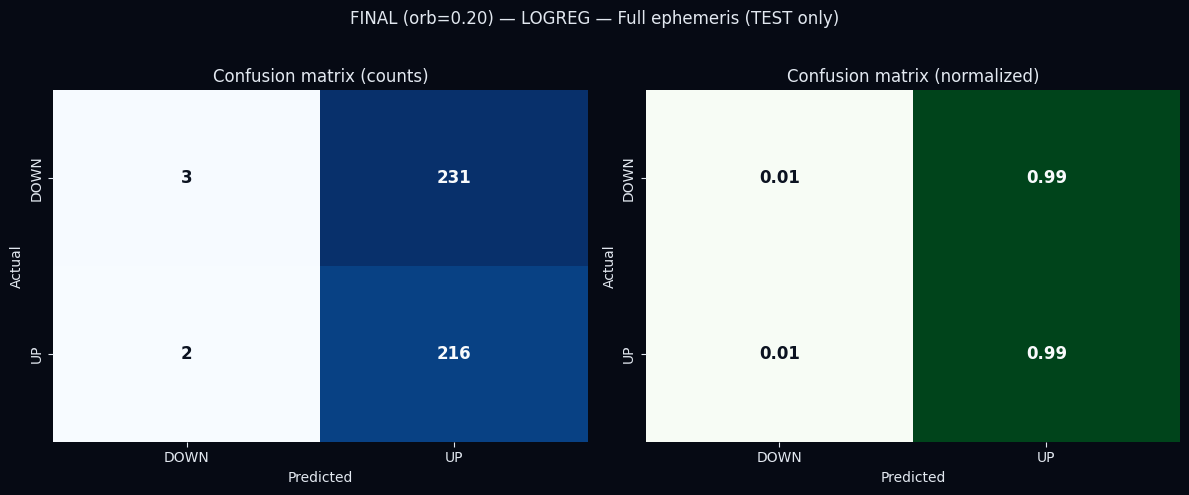

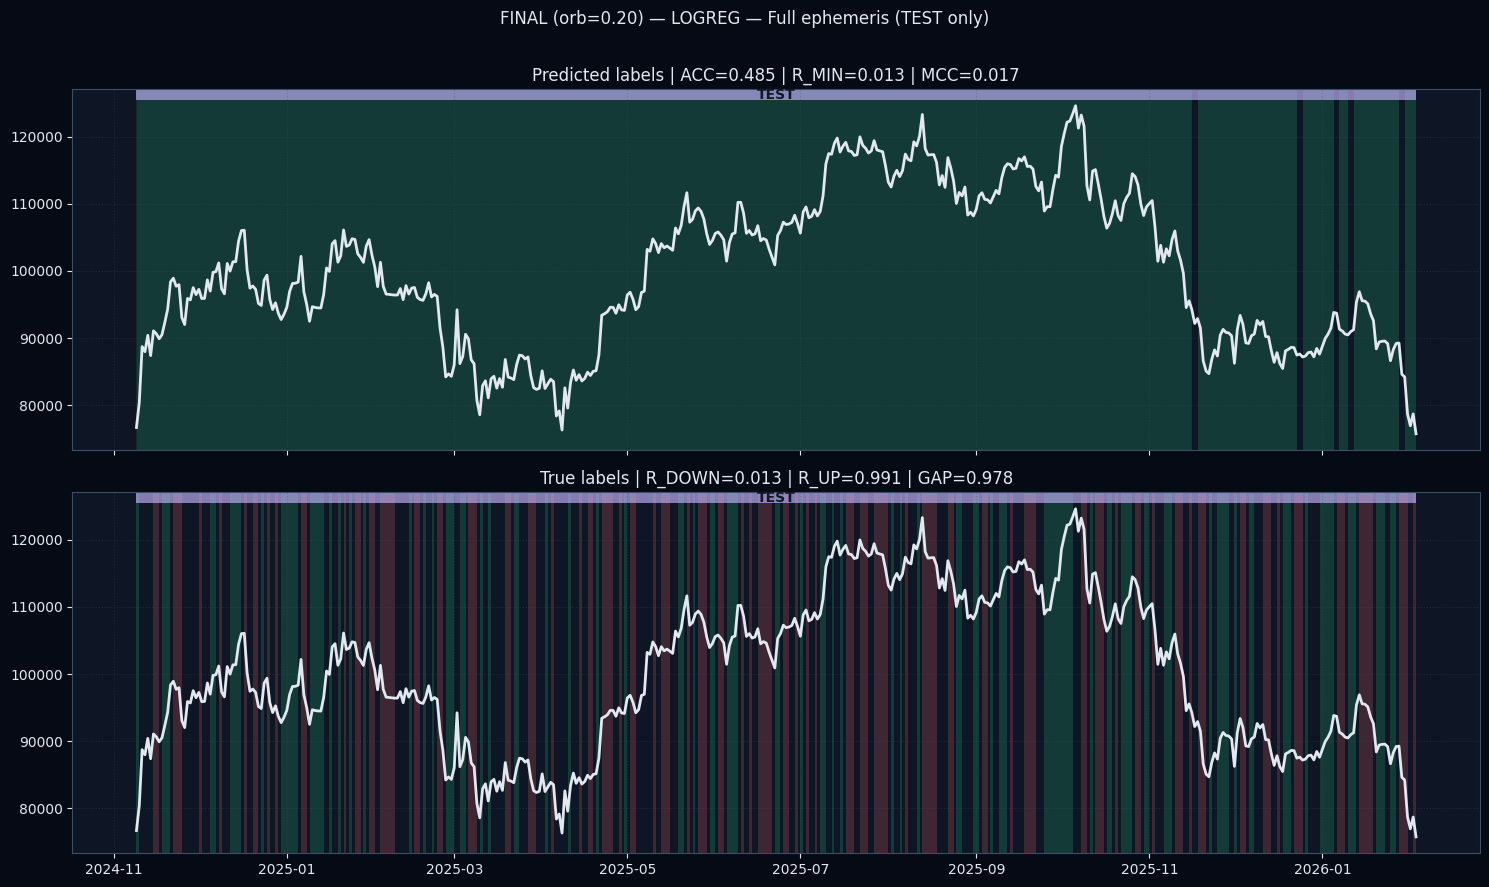

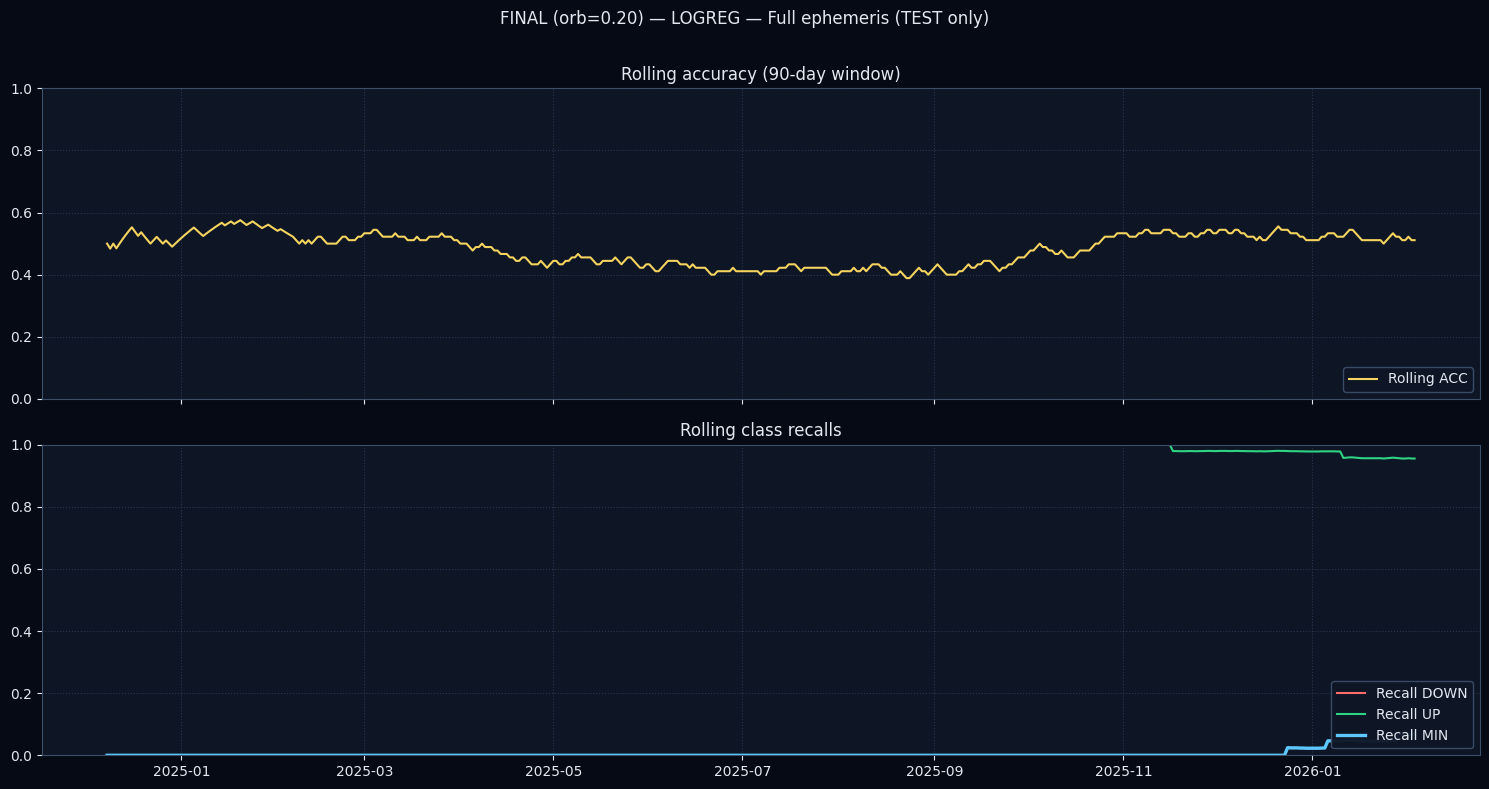

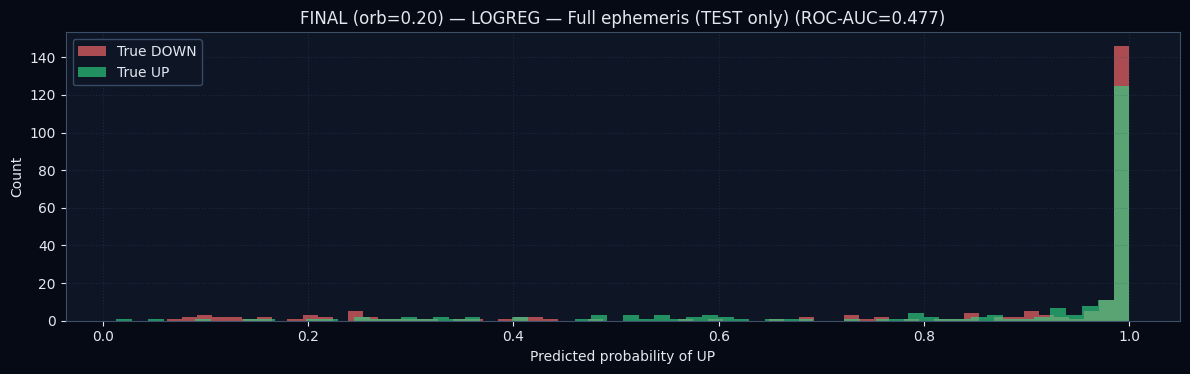

FINAL (orb=0.20) — LOGREG — Full ephemeris (TEST only)
ACC=0.4845 | BAL_ACC=0.5018 | MCC=0.0174 | R_DOWN=0.0128 | R_UP=0.9908 | R_MIN=0.0128
Significance vs random(50%): p-value=0.759743, 95% CI for ACC=[0.4388, 0.5305]


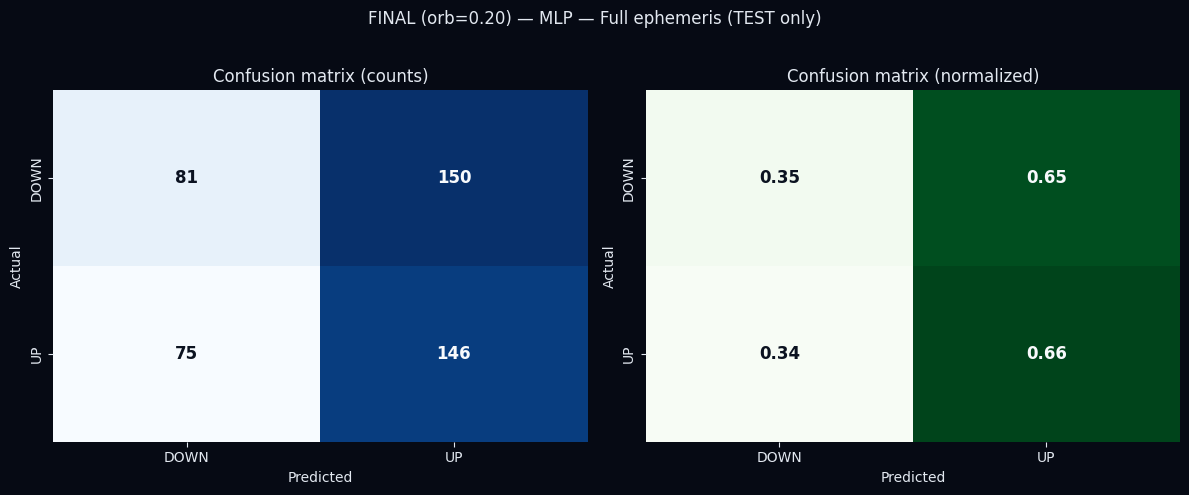

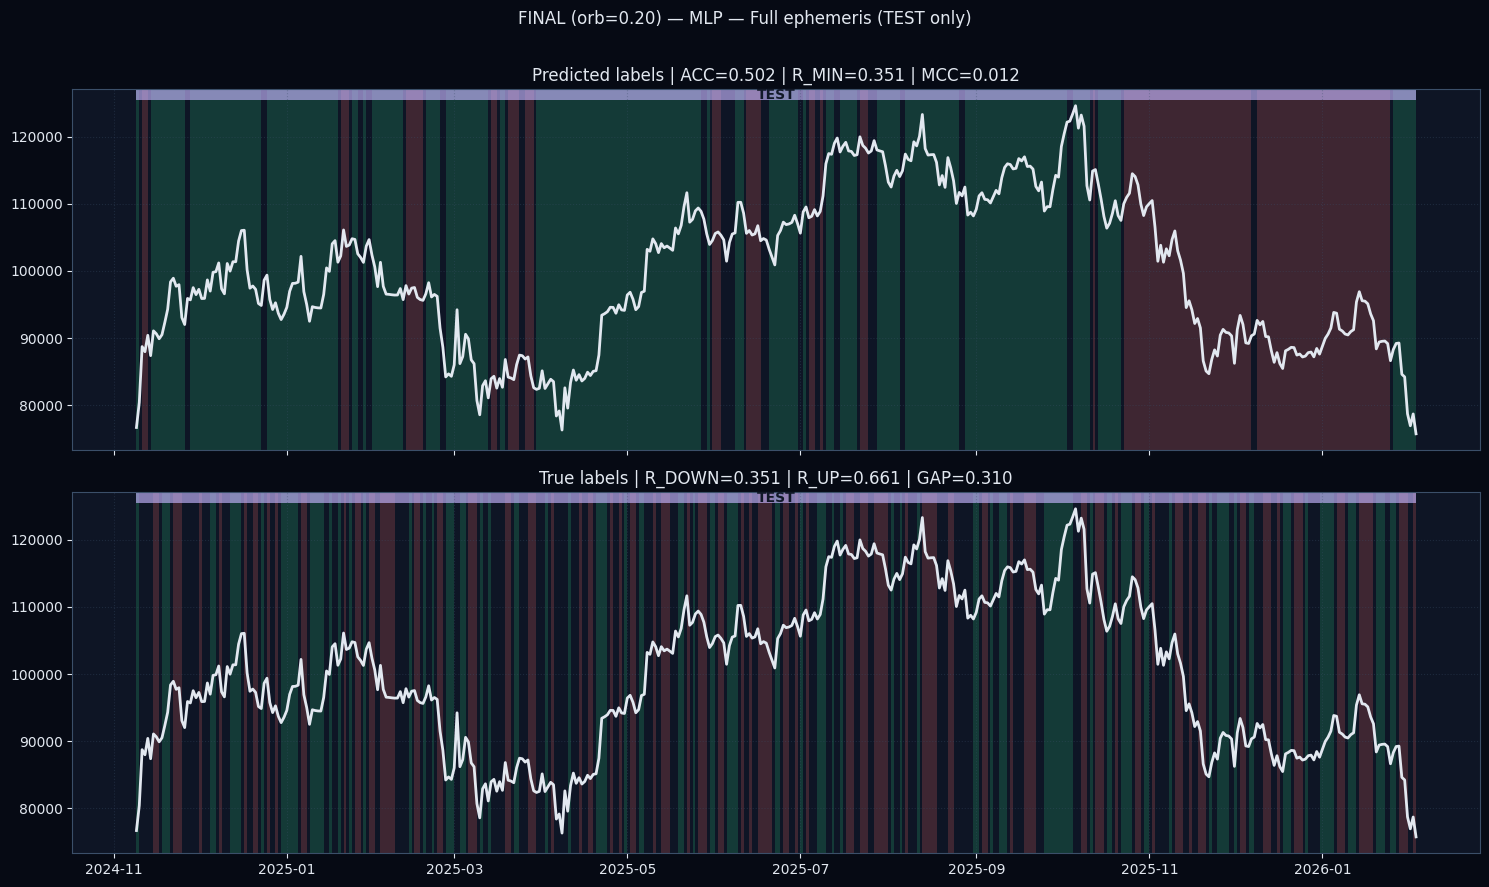

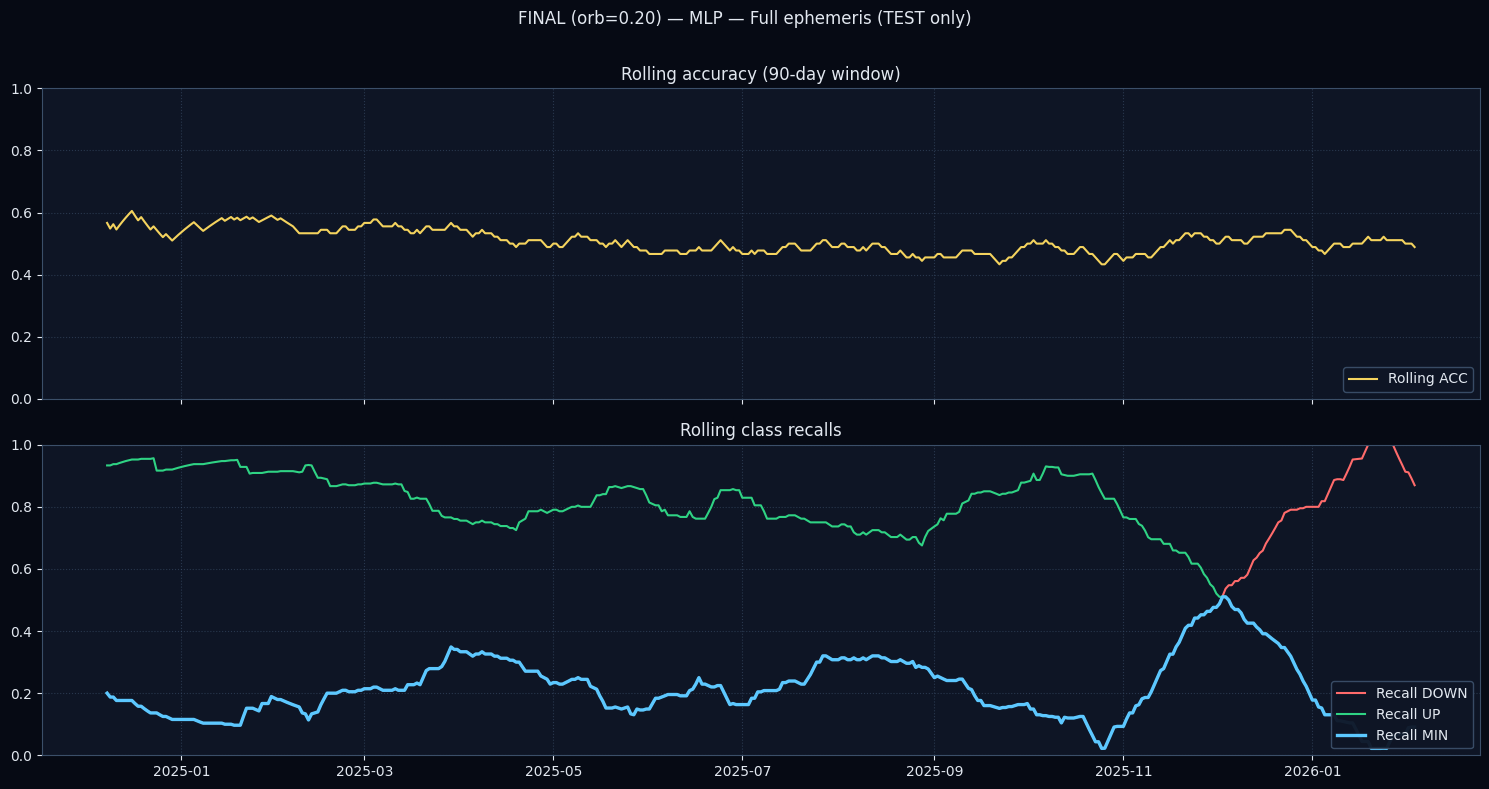

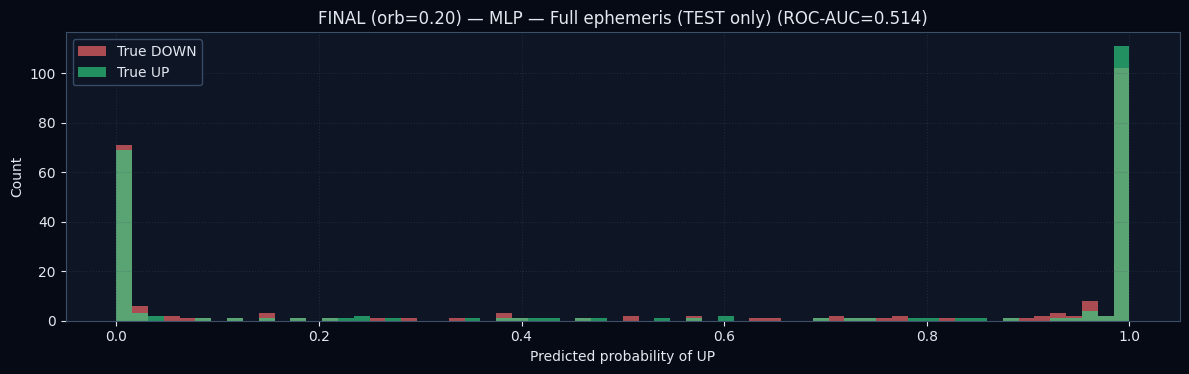

FINAL (orb=0.20) — MLP — Full ephemeris (TEST only)
ACC=0.5022 | BAL_ACC=0.5056 | MCC=0.0119 | R_DOWN=0.3506 | R_UP=0.6606 | R_MIN=0.3506
Significance vs random(50%): p-value=0.481246, 95% CI for ACC=[0.4563, 0.5481]


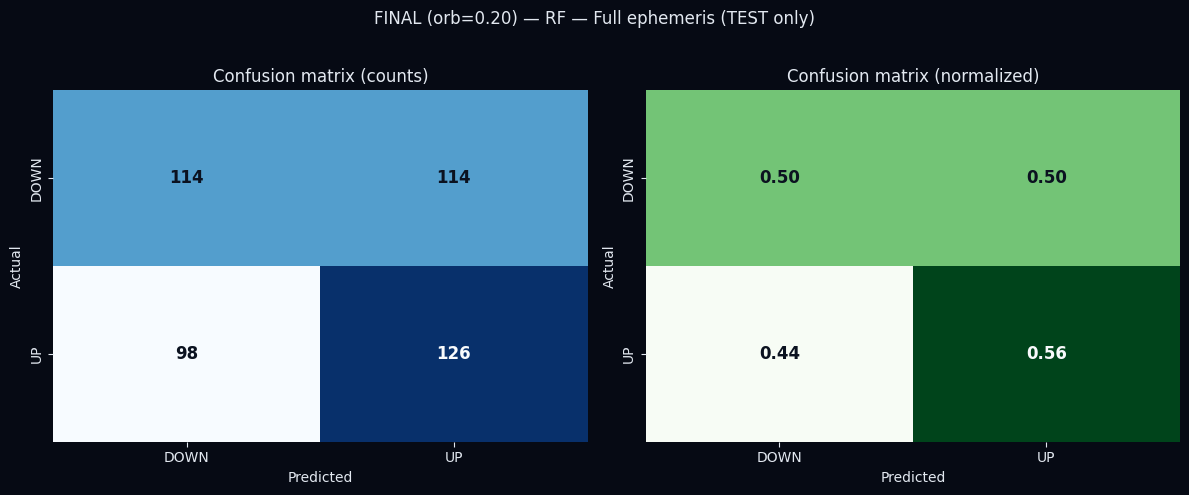

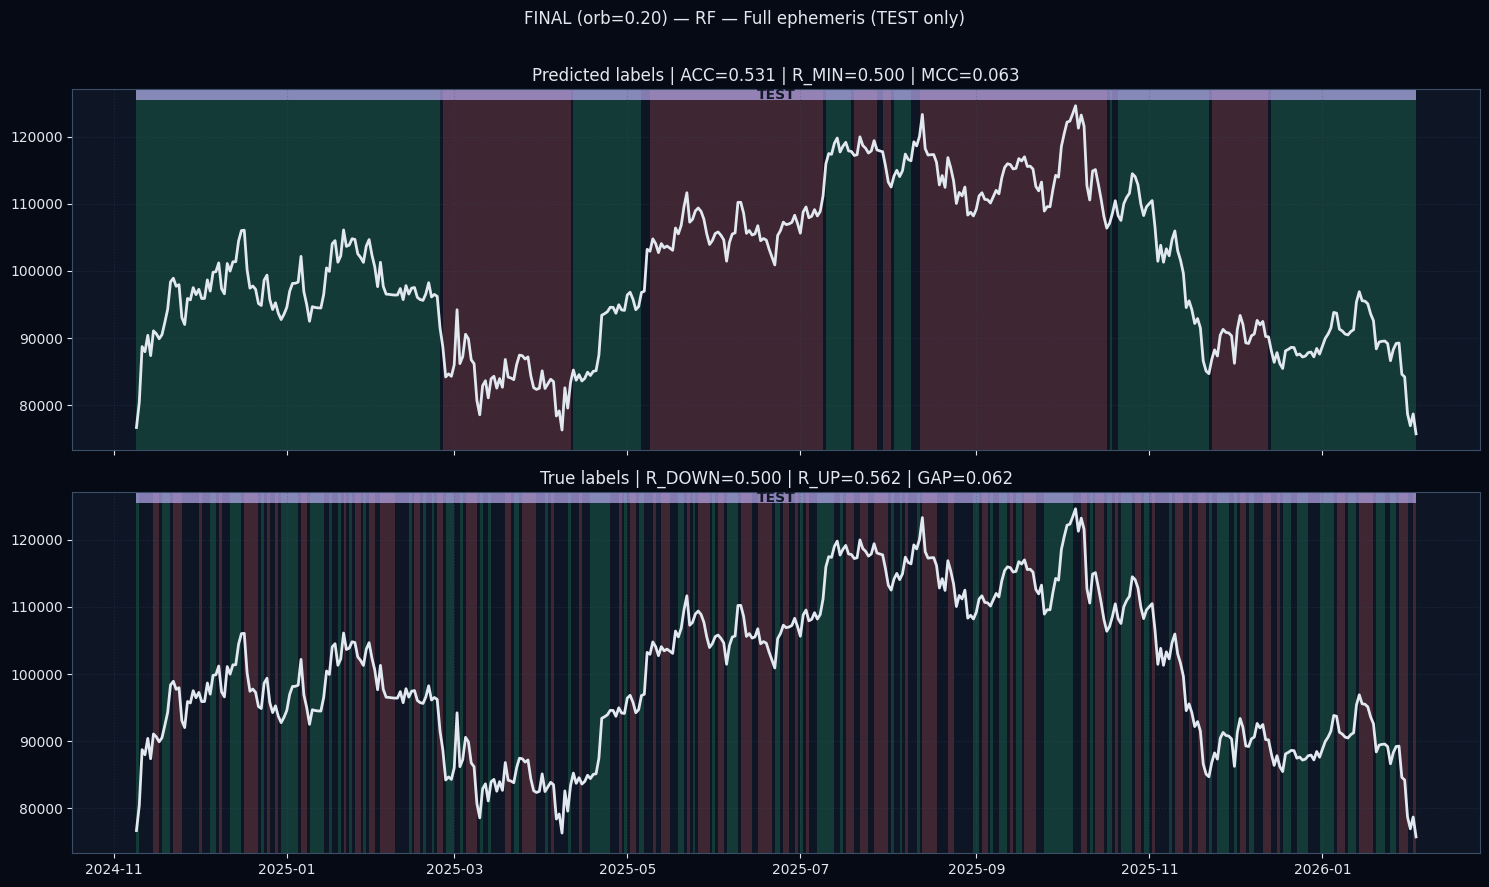

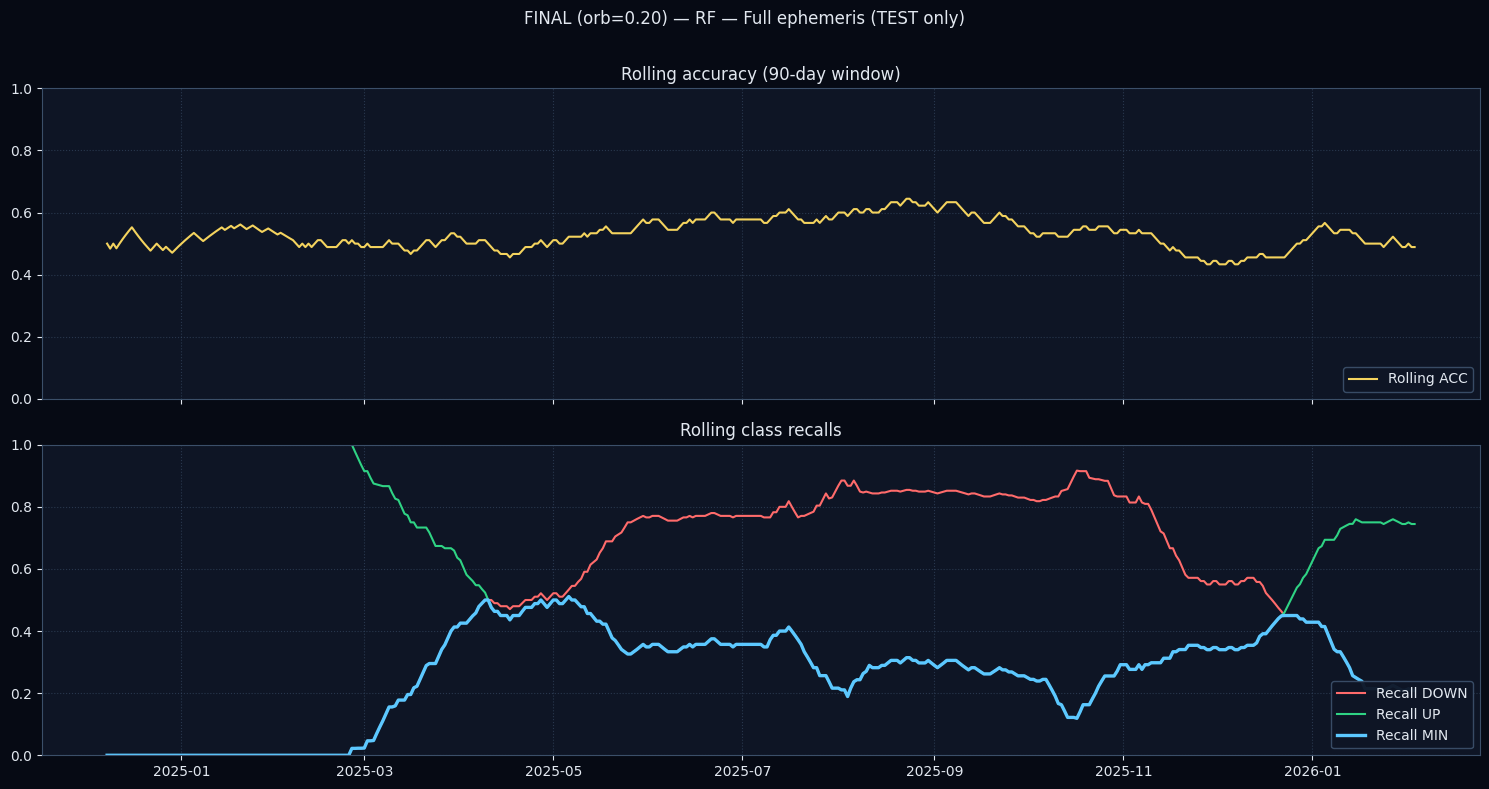

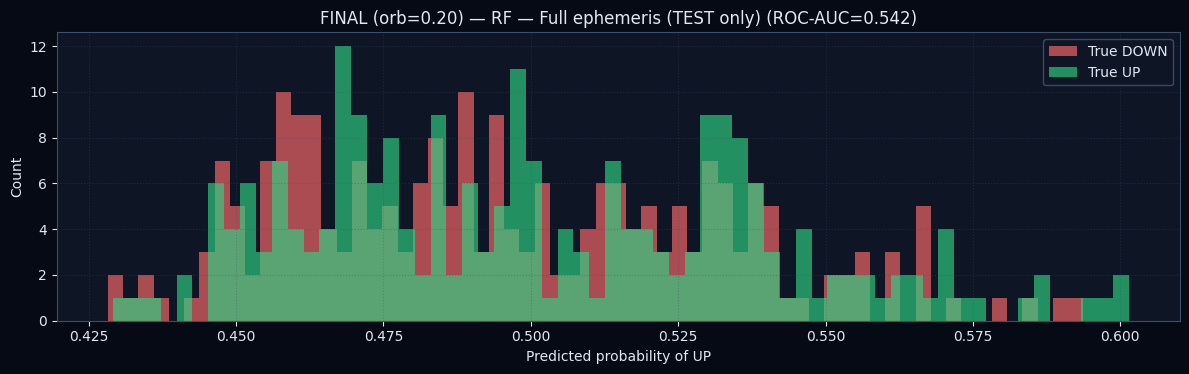

FINAL (orb=0.20) — RF — Full ephemeris (TEST only)
ACC=0.5310 | BAL_ACC=0.5312 | MCC=0.0626 | R_DOWN=0.5000 | R_UP=0.5625 | R_MIN=0.5000
Significance vs random(50%): p-value=0.102022, 95% CI for ACC=[0.4849, 0.5765]


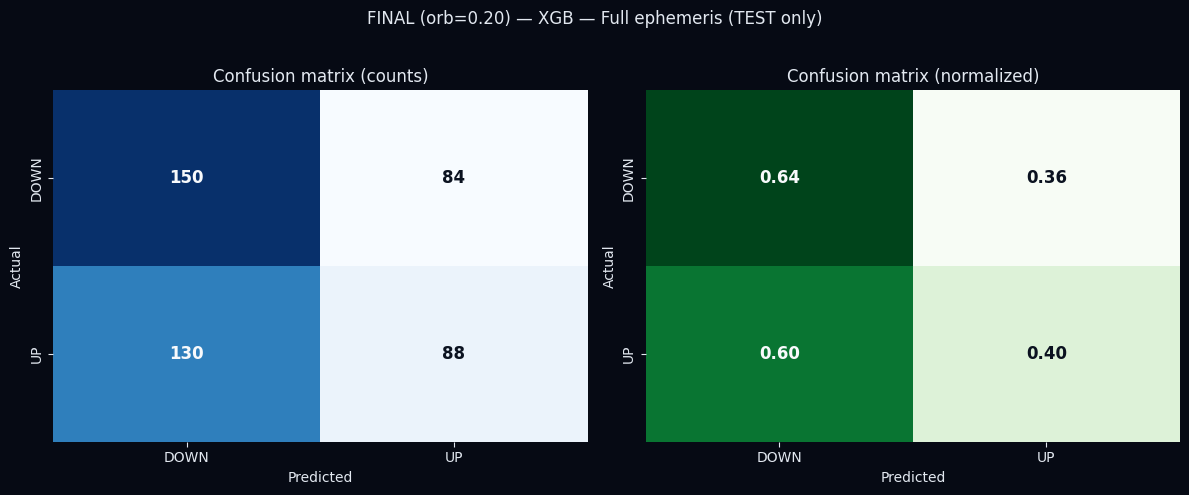

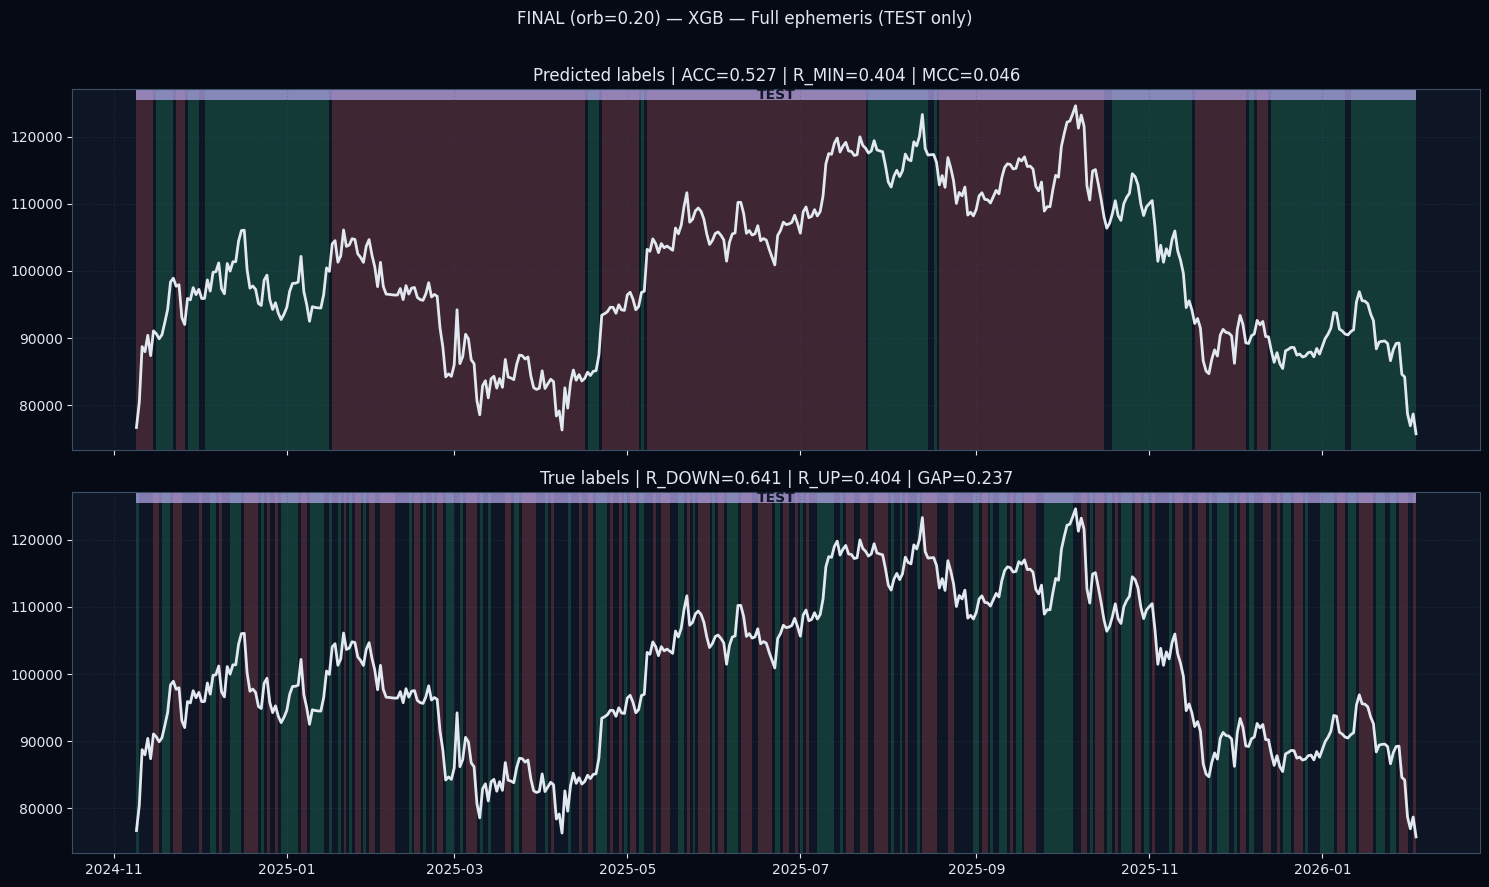

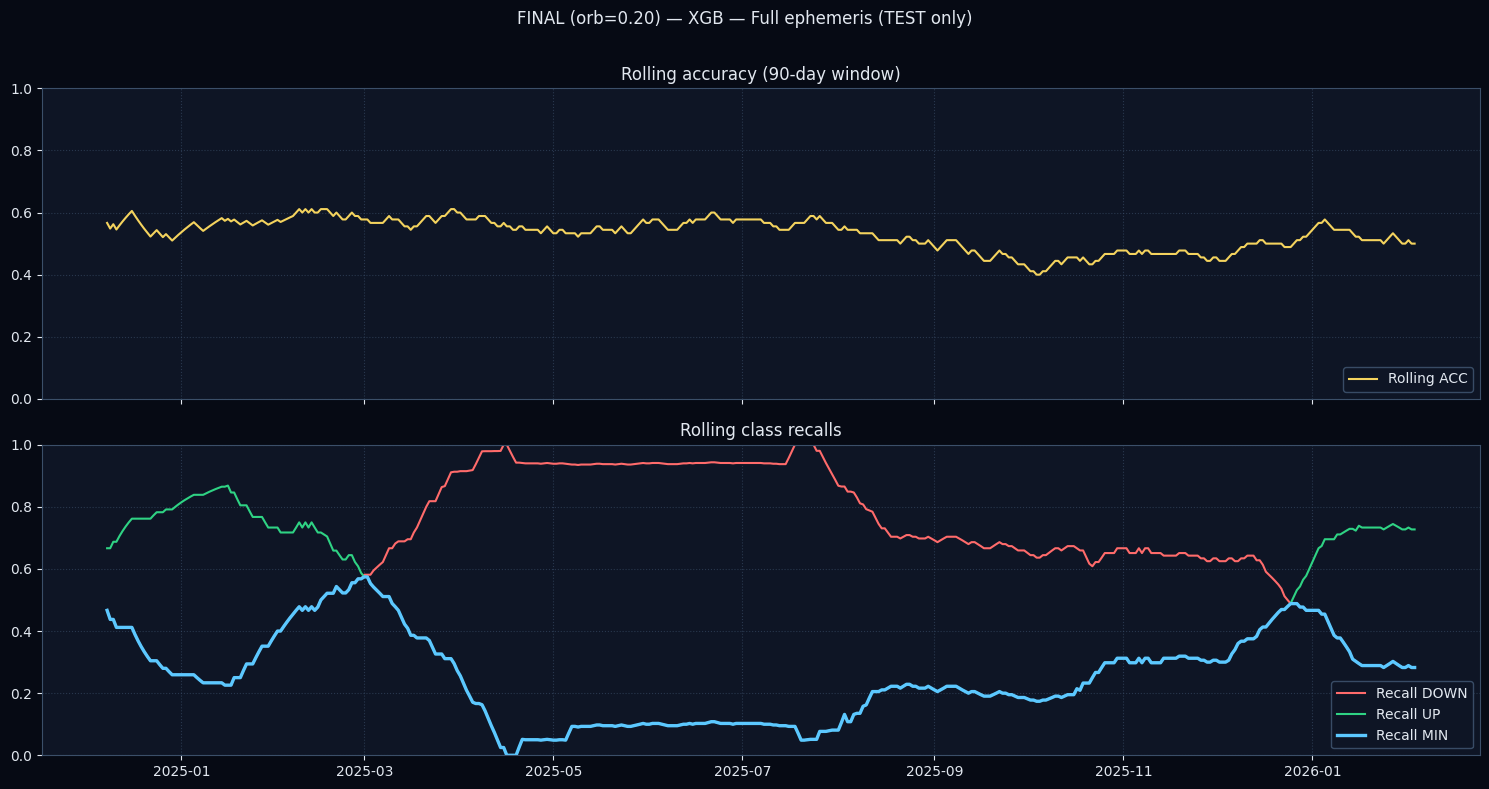

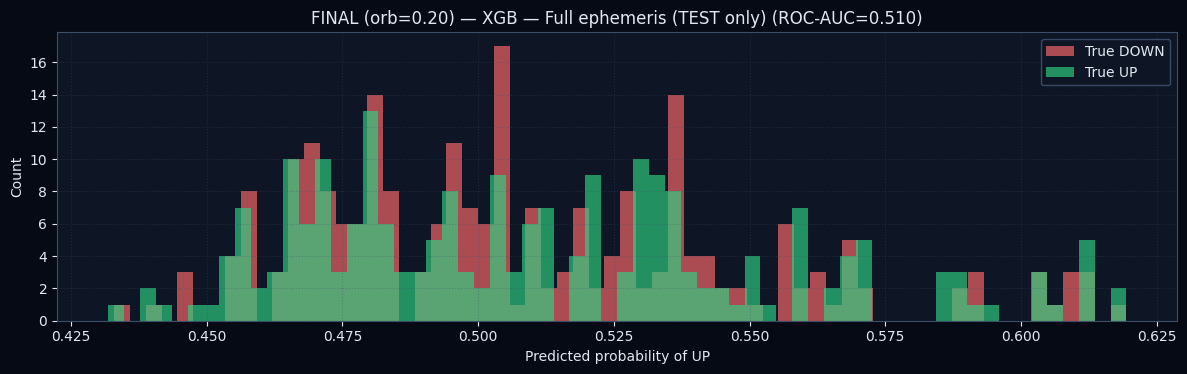

FINAL (orb=0.20) — XGB — Full ephemeris (TEST only)
ACC=0.5265 | BAL_ACC=0.5223 | MCC=0.0460 | R_DOWN=0.6410 | R_UP=0.4037 | R_MIN=0.4037
Significance vs random(50%): p-value=0.139657, 95% CI for ACC=[0.4805, 0.5722]


In [6]:
# -------------------------------------------
# FINAL confirmation on the best orb
# -------------------------------------------

if not DO_FINAL_FULL_GRID:
    print('DO_FINAL_FULL_GRID=False, skipping final confirmation.')
else:
    orb = float(best_orb)
    ns = cache_namespace_for_orb(orb)
    cfg = make_ephem_cfg(orb)

    print() 
    print('#' * 110)
    print(f'FINAL CONFIRMATION: orb_mult={orb:.2f}  cache_namespace={ns}')

    df_features = build_ephemeris_feature_set(
        df_market=df_market,
        cfg=cfg,
        cache_namespace=ns,
        use_cache=USE_CACHE,
        verbose=VERBOSE,
        progress=True,
    )

    # Full bakeoff: multiple models.
    bakeoff_final = run_moon_model_bakeoff(
        df_market=df_market,
        df_moon_features=df_features,
        gauss_windows=GAUSS_WINDOWS_FULL,
        gauss_stds=GAUSS_STDS_FULL,
        label_cfg=LABEL_CFG,
        model_specs=None,  # None => default list (logreg + rf + mlp)
        include_xgb=True,
        xgb_params=XGB_PARAMS,
        threshold_gap_penalty=THRESHOLD_GAP_PENALTY,
        threshold_prior_penalty=THRESHOLD_PRIOR_PENALTY,
        cache_namespace=ns,
        use_cache=USE_CACHE,
        verbose=VERBOSE,
    )

    best_by_val_final = bakeoff_final['best_by_val_table']
    best_runs_final = bakeoff_final['best_runs']

    print('Best-by-validation table (one row per model):')
    display(best_by_val_final)

    # Visual diagnostics for each winner model.
    #
    # NOTE (important): in bakeoff_utils we currently store model probabilities and
    # predicted labels only for the TEST rows (to keep caching smaller and to avoid
    # accidental confusion with train/val).
    #
    # That is why we slice split_role=='test' below.
    for model_name, run in best_runs_final.items():
        pred = run['predictions'].copy()
        df_test_plot = pred[pred['split_role'] == 'test'].copy().reset_index(drop=True)

        # Defensive cleaning: visuals and metrics should never see NaNs.
        df_test_plot = df_test_plot.dropna(subset=['close', 'target', 'pred_label', 'pred_proba_up']).reset_index(drop=True)

        y_true = df_test_plot['target'].to_numpy(dtype=int)
        y_pred = df_test_plot['pred_label'].to_numpy(dtype=int)
        y_prob = df_test_plot['pred_proba_up'].to_numpy(dtype=float)

        evaluate_with_visuals(
            df_plot=df_test_plot,
            y_true=y_true,
            y_pred=y_pred,
            y_prob_up=y_prob,
            title=f"FINAL (orb={orb:.2f}) — {model_name.upper()} — Full ephemeris (TEST only)",
            vis_cfg=VIS_CFG,
            show_visuals=True,
        )
